# Practical Machine Learning and Deep Learning
## Lesson 2: Tools and Processes for Machine Learning and Data Analysis

### Introduction

We will learn the basic tools and processes needed to analyze data and create machine learning models. An introduction to important tools such as programming languages, libraries, and development environments will help us prepare for practical data analysis tasks. We will also review the steps of data preparation, model training, and model evaluation to understand how these processes integrate to solve real-world machine learning problems.

### Goal
Your goal is to familiarize yourself with tools for data processing, model training and inference, and ways to log model metrics

## Submission
Your goal is to implement small neural network to classify images and generate `submission.csv` for the test set

## Libraries

### Frameworks

#### PyTorch
- PyTorch is an open-source machine learning library primarily developed by Facebook's AI Research lab. It is widely used for deep learning tasks.

#### TensorFlow
- TensorFlow is an open-source machine learning framework developed by Google. It's designed for building and training deep neural networks.

### Logging


##### Tensorboard

   - TensorBoard is a visualization tool provided by TensorFlow for monitoring and visualizing the training process and model performance during machine learning experiments.


##### WandB (Weights & Biases)

   - Weights & Biases is a platform that provides tools for tracking, visualizing, and optimizing machine learning experiments

##### ClearML
   - ClearML is an open-source machine learning platform designed to automate and streamline the end-to-end machine learning workflow, including data management, model training, and deployment.


### Data Preprocessing
   Data preprocessing involves cleaning, transforming, and organizing raw data to make it suitable for analysis or machine learning. This step is essential for improving data quality and model performance.

##### Pandas
 - Pandas is an open-source data manipulation and analysis library for Python. It provides data structures like DataFrames and Series, making it easy to work with structured data.

##### Matplotlib
- Matplotlib is a Python library for creating static, animated, and interactive visualizations in various formats. It's commonly used for data visualization and plotting.

##### Torchvision
- Torchvision is a PyTorch library that offers datasets, transformations, and models for computer vision tasks.

##### Torchtext
- Torchtext is a PyTorch library that offers datasets, transformations, and models for natural language processing tasks.
      

## Importing required Libraries

First we need to import necessary libraries:

[Pandas](https://pandas.pydata.org/) - For data analysis and manipulation

[Numpy](https://numpy.org/) - To deal with matrices

[Torch](https://pytorch.org/) - For buliding a neural network

[Warnings](https://docs.python.org/3/library/warnings.html) - To curb warnings to ensure smooth workflow

In [ ]:
# We will use tensorboard as logging tool.
# !pip install tensorboard

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## About the Data:


Each image in the [dataset](https://www.kaggle.com/competitions/pmldl-week-2-tools-and-processes/data) is 28x28. Each pixel has a single pixel-value in grayscale. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, has 785 columns:

first column is the digit that was drawn by the user
rest of the columns contain the pixel-values of the associated image.

## Data preprocessing



In [3]:
# read train data
train_df = pd.read_csv('mnist_train.csv', header=None)
test_df = pd.read_csv('mnist_test.csv', header=None)

print(train_df.head())

   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0    5    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    1    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    9    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]


Reshape the NumPy array into a 3D array with shape such that it arranges the data into 28x28 matrices (likely images), with the number of such matrices being automatically determined.

After that normalize the pixel values by dividing each value by 255.

# split images and labels

labels = train_df[0].values

images = train_df.drop(0, axis=1).values.reshape(-1, 28, 28) / 255

### Perform the data augmentation
Some of the examples of Image Augmentation could be to:
1.   Flip the image horizontally
2.   Rotate the image by up to 10 degrees



In [4]:
labels = train_df[0].values
images = train_df.drop(0, axis=1).values

print(f'Labels shape: {labels.shape}')
print(f'Images shape before reshape: {images.shape}')

images = images.reshape(-1, 28, 28)

Labels shape: (60000,)
Images shape before reshape: (60000, 784)


In [5]:
# Preprocess images
import torchvision.transforms as transforms

transform = transforms.Compose(
    [
        #   Here you can add more augmentations.
        #   See documentation: https://pytorch.org/vision/stable/transforms.html
        transforms.ToTensor()
    ]
)

train_labels = train_df[0].values
train_images = train_df.drop(0, axis=1).values.reshape(-1, 28, 28) / 255.0

In [6]:
# convert data to tensors
train_images_tensor = torch.stack([transform(image) for image in train_images]).float()
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)


### Plot the Images

It is always helpful to plot the images in a dataset before creating and training the neural network. It can help with:

1.  Checking Data Integrity
      Ensuring that the images are loaded correctly without any corruption.
2. Correct Labels
      Verifying that the images correspond to the correct labels.
3. Visual Inspection
      Gaining an understanding of what the images look like and the variety within the dataset.
4. Transformation Effects
      Ensuring that the applied transformations (e.g., normalization, augmentation) are behaving as expected.

In [7]:
def plot_images(images, captions=[], rows=2, columns=5, title="", **kwargs):
    """
    Plots images with captions

    :param images: list of images to plot
    :param captions: captions of images:
    :param rows: number of rows in figure
    :param columns: number of columns:
    :param title: super title of figure
    """
    fig = plt.figure(figsize=(6, 3))
    for i, img in enumerate(images):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(img, **kwargs)
        if i < len(captions):
            plt.title(captions[i])
        plt.axis("off")
    fig.suptitle(title)
    plt.show()


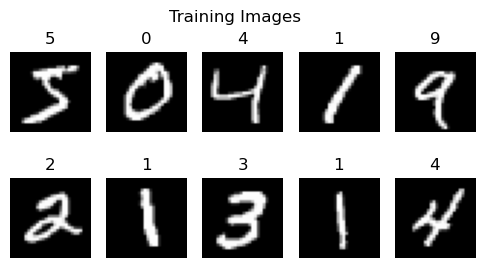

In [8]:
# Visualise 10 images from the dataset
plot_images(
    images=[train_images[i] for i in range(10)],
    captions=[str(train_labels[i]) for i in range(10)],
    rows=2,
    columns=5,
    title="Training Images",
    cmap="gray"
)

#### Create dataset and dataloaders

In [9]:
# Create dataset and dataloaders
processed_dataset = TensorDataset(train_images_tensor, train_labels_tensor)

# Set proportion and split dataset into train and validation parts
proportion = 0.8
train_size = int(proportion * len(processed_dataset))
val_size = len(processed_dataset) - train_size
train_dataset, val_dataset = random_split(processed_dataset, [train_size, val_size])

In [10]:
# Create Dataloaders for training
# Dataloader is iterable object over dataset
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


## Model
We will implement MLP(multi-layer perceptron).
An MLP is a class of feedforward artificial neural networks (ANNs) consisting of at least three layers of nodes: an input layer, one or more hidden layers, and an output layer. Each layer is fully connected to the next one in a feedforward manner.

> if you want higher score implement any suitable model you know and like

In [11]:
class ClassificationModel(nn.Module):
    """
    MLP (multi-layer perceptron) based classification model for MNIST
    """
    def __init__(self, num_classes=10):
        super(ClassificationModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.model(x)

## Training

Here is the sample function for training procedure.
We save the checkpoints with best accuracy score. For the inference you need to load it to the model.

> You can add early stopping if you want for better results

In [12]:
def train(
        model,
        optimizer,
        loss_fn,
        train_loader,
        val_loader,
        writer,
        epochs=1,
        device="cpu",
        ckpt_path="best.pt",
):
    # best score for checkpointing
    best = 0.0

    # iterating over epochs
    for epoch in range(epochs):
        # training loop description
        train_loop = tqdm(
            enumerate(train_loader, 0), total=len(train_loader), desc=f"Epoch {epoch}"
        )
        model.train()
        train_loss = 0.0
        # iterate over dataset
        for i, data in train_loop:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass and loss calculation
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # backward pass
            loss.backward()

            # optimizer run
            optimizer.step()

            train_loss += loss.item()
            train_loop.set_postfix({"loss": loss.item()})

        # write loss to tensorboard
        writer.add_scalar("Loss/train", train_loss / len(train_loader), epoch)

        # validation
        correct = 0
        total = 0
        with torch.no_grad():
            model.eval()  # evaluation mode
            val_loop = tqdm(enumerate(val_loader, 0), total=len(val_loader), desc="Val")
            for i, data in val_loop:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                # type code
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                # type code
                correct += (predicted == labels).sum().item()

                val_loop.set_postfix({"acc": correct / total})

            if correct / total > best:
                torch.save(model.state_dict(), ckpt_path)
                # type code
                best = correct / total

In [13]:
# Type code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ClassificationModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
writer = SummaryWriter()

In [14]:
train(
    model,
    optimizer,
    loss_fn,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    writer=writer,
)


Val: 100%|██████████| 375/375 [00:00<00:00, 1104.99it/s, acc=0.947]


In [ ]:
# Kaggle has no support of viewing tensorboard. Run this if you are using your machine
# to see logs.
# !tensorboard --logdir .

## Inference
Here you need to perform inference of trained model on test data.

Load the best checkpoint from training to the model and run inference

In [15]:
# load best checkpoint to model
model = ClassificationModel().to(device)
ckpt = torch.load("best.pt")
model.load_state_dict(ckpt)

<All keys matched successfully>

In [16]:
def predict(model, test_loader, device):
    """
    Run model inference on test data
    """
    predictions = []
    with torch.no_grad():
        model.eval()  # evaluation mode
        test_loop = tqdm(enumerate(test_loader, 0), total=len(test_loader), desc="Test")
        for i, data in test_loop:
            inputs = data[0].to(device)
            outputs = model(inputs)
            # Type coce
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.tolist())
    return predictions

In [17]:
# process test data and run inference on it
test_images = test_df.values.reshape(-1, 28, 28) / 255
test_images_tensor = torch.stack([transform(image) for image in test_images]).float()

test_loader = DataLoader(TensorDataset(test_images_tensor), batch_size=batch_size, shuffle=False)
# Generate predictions
predictions = predict(model, test_loader, device=device)

Test: 100%|██████████| 313/313 [00:00<00:00, 4175.40it/s]


In [18]:
# generate the submission file
submission_df = pd.DataFrame({'ImageId': np.arange(1, len(predictions) + 1), 'Label': predictions})
submission_df.to_csv('submission.csv', index=False)


In [19]:
df2 = pd.read_csv('submission.csv')
df2.head()

,ImageId,Label
0,1,7
1,2,2
2,3,1
3,4,0
4,5,4
